In [1]:
import os, sys
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import scanpy as sc
from torch.utils.data import DataLoader, random_split
import lightning.pytorch as pl
from lightning.pytorch import Trainer, seed_everything
import anndata
import pickle

script_dir = Path().resolve()
repo_dir = script_dir
src_dir = repo_dir / 'src'
data_dir = repo_dir / 'data'
sys.path.append(str(src_dir))
sys.path.append(str(data_dir))

from dataset.read_scrnaseq_data import read_cell_by_gene_matrix, convert_cell_by_gene_matrix_to_anndata, read_hires_metadata_file, ensure_same_genes_in_dataframes
from dataset.preprocessing import scrna_seq_normalization
from dataset.dataloader import AnnDataDataset
from dataset.precompute_scrnaseq_data import *

from model.scRNA_AE import scRNASeqAE
from model.scRNA_E_C import scRNASeqE_simCLR, scRNASeqEncoder, scRNASeqDecoder, scRNASeqProjectionHead, scRNASeqE_VICReg, scRNASeqE_VICRegLarge, scRNASeqE_VICRegExpanderLarge, scRNASeqE_VICRegExpander


PARAMETERS = {
    'hvgs': 20116,
    'num_genes': 20116,
    'latent_dimension': 50,
    'target_sum': 10000,
    'batch_size': 1024,
    'num_epochs': 5,
}

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = False
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.dpi'] = 600
plt.rcParams["figure.figsize"] = (12, 8)

In [13]:
VERSION = 'v3,5'
tm_adata_train_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_train_length_normalized_{VERSION}.pkl'
with open(tm_adata_train_path, 'rb') as f:
    tm_adata_train = pickle.load(f)
tm_adata_train = tm_adata_train.copy()

tm_adata_test_path = data_dir / 'pickled' / 'tabula_muris' / f'tm_adata_test_length_normalized_{VERSION}.pkl'
with open(tm_adata_test_path, 'rb') as f:
    tm_adata_test = pickle.load(f)
tm_adata_test = tm_adata_test.copy()

In [3]:
!pwd

/users/wli115/data/rsingh47/wli115/scContrast


In [5]:
from glob import glob

model_checkpoints_paths = glob(r'./ablation_experiments/best_trial_results/v3,5/checkpoints/*')
# model_checkpoints_paths = model_checkpoints_paths[5:10]
model_checkpoints_paths

['./ablation_experiments/best_trial_results/v3,5/checkpoints/genes18244_batch8192_latent128_gene_normalized_seed1140948718_ctCS_ctmsgG_DO_gRS_gSS_epoch=49-val_loss=1.0085.ckpt',
 './ablation_experiments/best_trial_results/v3,5/checkpoints/genes18244_batch8192_latent128_gene_normalized_seed1260752463_ctCS_ctmsgG_DO_gRS_epoch=48-val_loss=0.8564.ckpt',
 './ablation_experiments/best_trial_results/v3,5/checkpoints/genes18244_batch8192_latent128_gene_normalized_seed3013125611_ctCS_DO_gRS_gSS_epoch=45-val_loss=1.1731.ckpt',
 './ablation_experiments/best_trial_results/v3,5/checkpoints/genes18244_batch8192_latent128_gene_normalized_seed3089049308_ctCS_ctmsgG_gRS_gSS_epoch=49-val_loss=0.7808.ckpt',
 './ablation_experiments/best_trial_results/v3,5/checkpoints/genes18244_batch8192_latent128_gene_normalized_seed3334476422_ctmsgG_DO_gRS_gSS_epoch=49-val_loss=0.6638.ckpt',
 './ablation_experiments/best_trial_results/v3,5/checkpoints/genes18244_batch8192_latent128_gene_normalized_seed947116407_ctCS_ct

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
representations = {}
names = []
for model_checkpoints_path in model_checkpoints_paths:
    name = '_'.join(model_checkpoints_path.split('genes18244_batch8192_latent128_gene_normalized_')[-1].split('_')[1:]).split('_epoch')[0]
    names.append('X_latent_'+name)
    with torch.no_grad():
        VICreg_model = scRNASeqE_VICRegExpander.load_from_checkpoint(model_checkpoints_path)
        VICreg_model.to(device)
        VICreg_model.eval()
        latent_representations = VICreg_model.encoder(
            torch.tensor(tm_adata_test.X.toarray(), dtype=torch.float32).to(device)
            )
        latent_representations = latent_representations.detach().cpu().numpy()
    representations[name] = latent_representations
    # embeds.append(latent_representations)
    tm_adata_test.obsm[f'X_latent_{name}'] = latent_representations

In [16]:
tm_adata_test

AnnData object with n_obs × n_vars = 61774 × 18244
    obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
    var: 'n_cells-0', 'n_cells-1'
    uns: 'log1p'
    obsm: 'X_latent_ctCS_ctmsgG_DO_gRS_gSS', 'X_latent_ctCS_ctmsgG_DO_gRS', 'X_latent_ctCS_DO_gRS_gSS', 'X_latent_ctCS_ctmsgG_gRS_gSS', 'X_latent_ctmsgG_DO_gRS_gSS', 'X_latent_ctCS_ctmsgG_DO_gSS'

In [24]:
names

['X_latent_ctCS_ctmsgG_DO_gRS_gSS',
 'X_latent_ctCS_ctmsgG_DO_gRS',
 'X_latent_ctCS_DO_gRS_gSS',
 'X_latent_ctCS_ctmsgG_gRS_gSS',
 'X_latent_ctmsgG_DO_gRS_gSS',
 'X_latent_ctCS_ctmsgG_DO_gSS']

In [22]:
tm_adata_test.X

<61774x18244 sparse matrix of type '<class 'numpy.float32'>'
	with 131162723 stored elements in Compressed Sparse Row format>

In [25]:
from scib_metrics.benchmark import Benchmarker
bm_uce = Benchmarker(
    tm_adata_test,
    batch_key='tech',
    label_key='Celltype',
    embedding_obsm_keys=names,
    n_jobs=-1
)
bm_uce.benchmark()

/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Embeddings:   0%|                                                                                                                                                              | 0/6 [00:00<?, ?it/s]2025-04-19 19:45:26.985061: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.8.61). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  17%|█████████████████████████                                                                                                                             | 1/6 [01:20<06:42, 80.49s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  33%|██████████████████████████████████████████████████                                                                                                    | 2/6 [02:13<04:16, 64.05s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  50%|███████████████████████████████████████████████████████████████████████████                                                                           | 3/6 [03:01<02:50, 56.76s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  67%|████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 4/6 [03:50<01:47, 53.87s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings:  83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 5/6 [04:36<00:50, 50.85s/it]/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.

INFO     CD4-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         
INFO     CD8-positive, alpha-beta T cell consists of a single batch or is too small. Skip.                         


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     Schwann cell consists of a single batch or is too small. Skip.                                            


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     bulge keratinocyte consists of a single batch or is too small. Skip.                                      
INFO     duct epithelial cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     fibroblast consists of a single batch or is too small. Skip.                                              
INFO     hepatic stellate cell consists of a single batch or is too small. Skip.                                   


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     mature NK T cell consists of a single batch or is too small. Skip.                                        


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     neutrophil consists of a single batch or is too small. Skip.                                              


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)
/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and 

INFO     plasmacytoid dendritic cell consists of a single batch or is too small. Skip.                             
INFO     skeletal muscle cell consists of a single batch or is too small. Skip.                                    


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_kbet.py:181: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  comp_size = pd.value_counts(labs)


INFO     smooth muscle cell consists of a single batch or is too small. Skip.                                      
INFO     stem cell of epidermis consists of a single batch or is too small. Skip.                                  


/oscar/data/rsingh47/wli115/scGrapHiCv2/pytorch.venv/lib64/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:25<00:00, 54.17s/it]


In [27]:
bm_uce.__dict__

{'_adata': AnnData object with n_obs × n_vars = 61774 × 18244
     obs: 'age', 'cell', 'Celltype', 'cell_ontology_id', 'free_annotation', 'method', 'mouse.id', 'n_genes', 'sex', 'subtissue', 'tissue', 'tissue_free_annotation', 'tech', 'FACS.selection', 'n_counts', 'batch', 'celltype_tech_availability'
     var: 'n_cells-0', 'n_cells-1'
     uns: 'log1p', 'pca'
     obsm: 'X_latent_ctCS_ctmsgG_DO_gRS_gSS', 'X_latent_ctCS_ctmsgG_DO_gRS', 'X_latent_ctCS_DO_gRS_gSS', 'X_latent_ctCS_ctmsgG_gRS_gSS', 'X_latent_ctmsgG_DO_gRS_gSS', 'X_latent_ctCS_ctmsgG_DO_gSS', 'X_pca'
     varm: 'PCs',
 '_embedding_obsm_keys': ['X_latent_ctCS_ctmsgG_DO_gRS_gSS',
  'X_latent_ctCS_ctmsgG_DO_gRS',
  'X_latent_ctCS_DO_gRS_gSS',
  'X_latent_ctCS_ctmsgG_gRS_gSS',
  'X_latent_ctmsgG_DO_gRS_gSS',
  'X_latent_ctCS_ctmsgG_DO_gSS'],
 '_pre_integrated_embedding_obsm_key': 'X_pca',
 '_bio_conservation_metrics': BioConservation(isolated_labels=True, nmi_ari_cluster_labels_leiden=False, nmi_ari_cluster_labels_kmeans=True, 

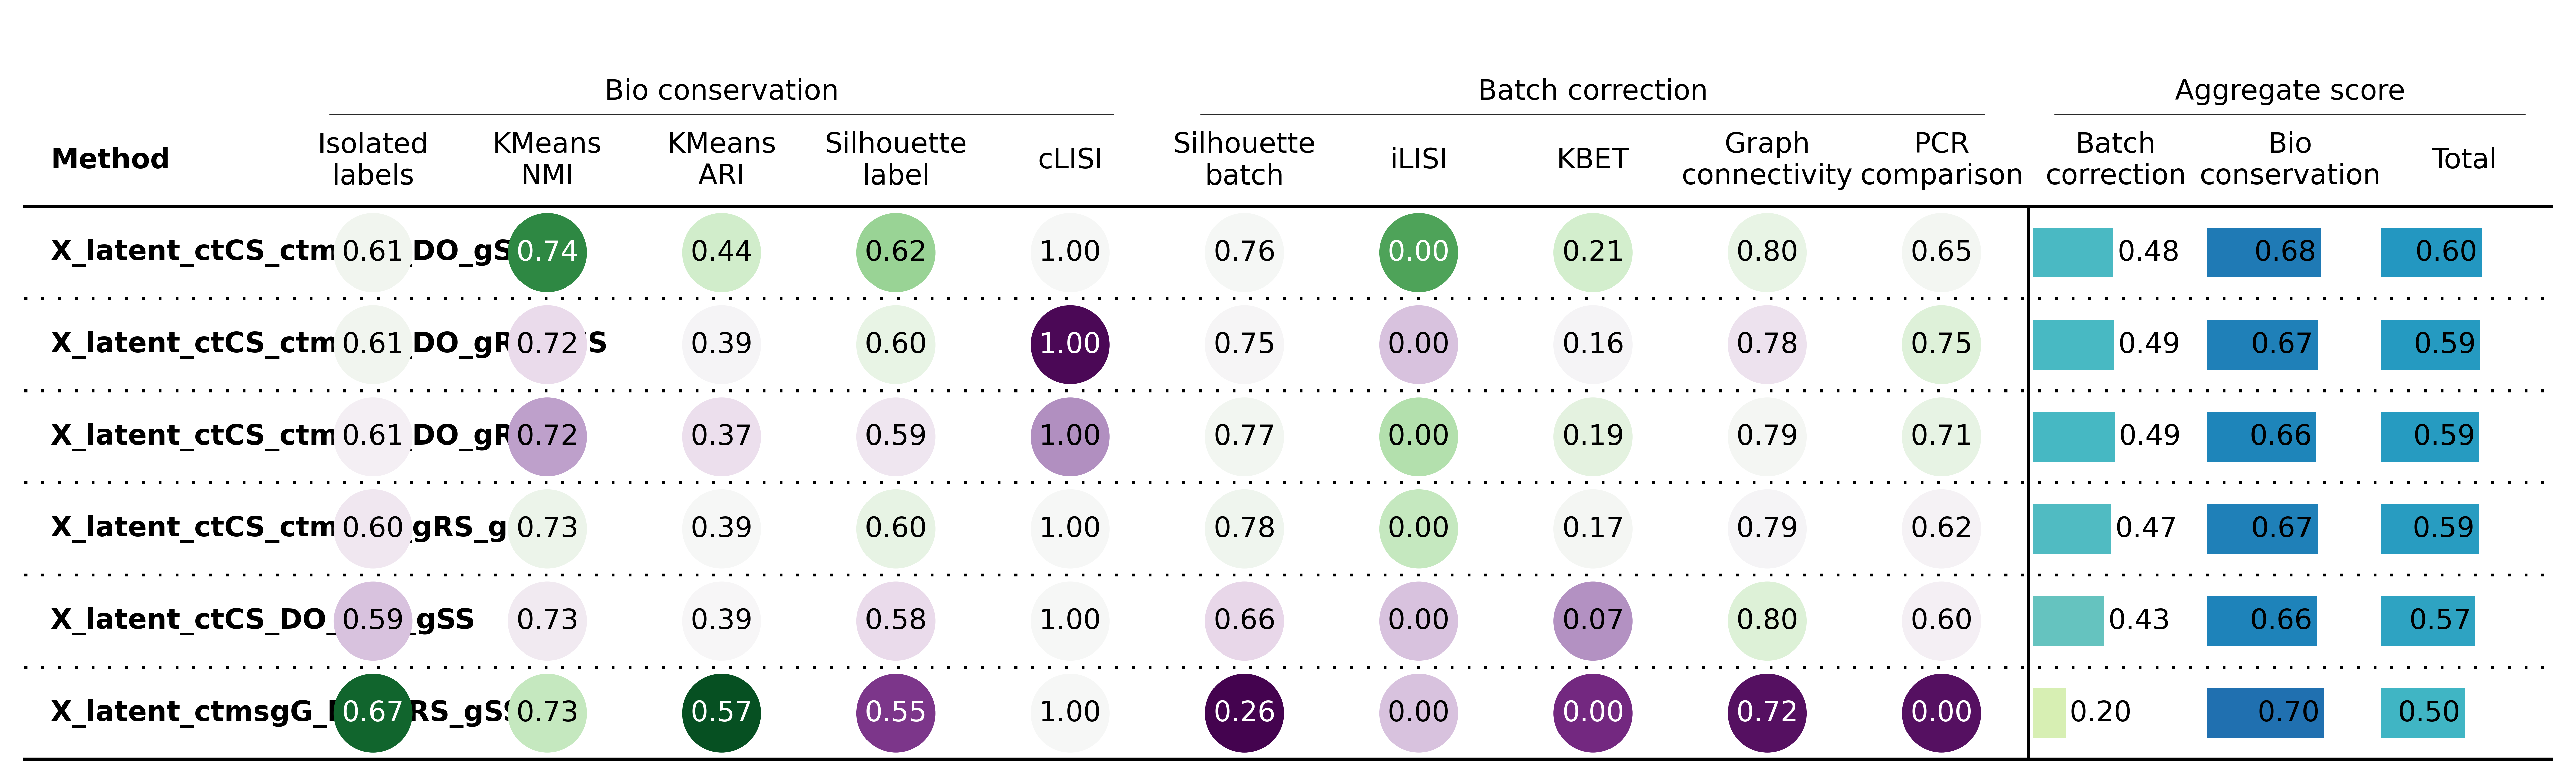

FileNotFoundError: [Errno 2] No such file or directory: 'figures/scib_results.svg'

In [26]:
bm_uce.plot_results_table(min_max_scale=False, save_dir='figures')

In [34]:
output_folder = f'./ablation_experiments/figures'
os.makedirs(output_folder, exist_ok=True)

for name in names:
    print(name)
    print('getting neighbors')
    sc.pp.neighbors(tm_adata_test, use_rep=name)
    print('getting umap')
    sc.tl.umap(tm_adata_test)
    print('plotting')
    fig = sc.pl.umap(tm_adata_test, color='Celltype', legend_loc=None, title='', frameon=False, size=50, return_fig=True)
    # fig.show()
    fig.savefig(f'{output_folder}/celltypes/{name.split("X_latent_")[-1]}')
    plt.close(fig)
    

X_latent_ctCS_ctmsgG_DO_gRS_gSS
getting neighbors
getting umap
plotting
X_latent_ctCS_ctmsgG_DO_gRS
getting neighbors
getting umap
plotting
X_latent_ctCS_DO_gRS_gSS
getting neighbors
getting umap
plotting
X_latent_ctCS_ctmsgG_gRS_gSS
getting neighbors
getting umap
plotting
X_latent_ctmsgG_DO_gRS_gSS
getting neighbors
getting umap
plotting
X_latent_ctCS_ctmsgG_DO_gSS
getting neighbors
getting umap
plotting
